# Tutorial 3: SVD Matrix Construction and Window Sizes

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ADSCIAN/ssalib/blob/main/notebooks/03_ssa_svd_matrices.ipynb)

In this tutorial, you will learn:
- How to construct trajectory matrices using Broomhead-King (BK) and Vautard-Ghil (VG) approaches
- The impact of window size selection on SSA decomposition
- Best practices for parameter selection in SSA

## Imports and Data

We use monthly sea surface temperature data (1982-2023) as our example dataset.

In [1]:
#!pip install ssalib # Uncomment to install ssalib
import matplotlib.pyplot as plt

from ssalib import SingularSpectrumAnalysis
from ssalib.datasets import load_sst

sst = load_sst()
sst.head()

Date
1982-01-15    20.10
1982-02-15    20.13
1982-03-15    20.21
1982-04-15    20.19
1982-05-15    20.15
Name: Value, dtype: float64

## Matrix Construction Methods

SSA offers three approaches for constructing the SVD matrix to be decomposed:

1. **Broomhead & King (BK) Trajectory Matrix (`'bk_trajectory'`)**: Constructs a trajectory matrix directly from lagged copies of the time series.
2. **Broomhead & King (BK) Covariance Matrix (`'bk_covariance'`)**: The covariance matrix of the Broomhead & King trajectory matrix
3. **Vautard & Ghil (VG) Covariance Matrix (`'vg_covariance'`)**: Lagged covariance matrix having a Toeplitz structure.

Approaches 1 & 2 result in the same singular systems, although decomposition performance may differ.
The VG approach is usually recommended for stationary time series. All matrices require a `window` argument, which is set to half of the length of the time series by default.

### Using Default Window Length

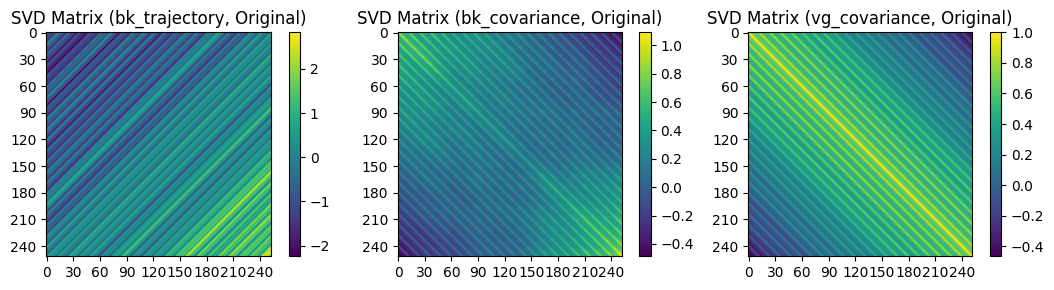

In [2]:
ssa_bk_trajectory = SingularSpectrumAnalysis(sst,
                                             svd_matrix_kind='bk_trajectory')
ssa_bk_covariance = SingularSpectrumAnalysis(sst,
                                             svd_matrix_kind='bk_covariance')
ssa_vg_covariance = SingularSpectrumAnalysis(sst,
                                             svd_matrix_kind='vg_covariance')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11, 3))
ssa_bk_trajectory.plot(kind='matrix', ax=axes[0])
ssa_bk_covariance.plot(kind='matrix', ax=axes[1])
ssa_vg_covariance.plot(kind='matrix', ax=axes[2])
fig.tight_layout()


- The `bk_trajectory` matrix is a unit-delay lagged
  embedding of the time series of shape `(window, k)`, where
  the maximum lag `k` is given by `len(sst) - window + 1`.
  The `bk_trajectory` matrix in a Hankel matrix, i.e., with its
  anti-diagonal elements equal.
- The `bk_covariance` matrix is the covariance matrix of shape `(window,
  window)` given by `1/k * bk_trajectory @ bk_trajectory.T`.
- The `vg_covariance` matrix is a covariance matrix
  of shape `(window, window)` with a Toeplitz structure, i.e.,
  with its diagonal elements equal.

**Note**: the `bk_trajectory` matrix has values ranging mostly between -2 and 2 given that the `sst` timeseries is standardized by default.

### Using Custom Window Length

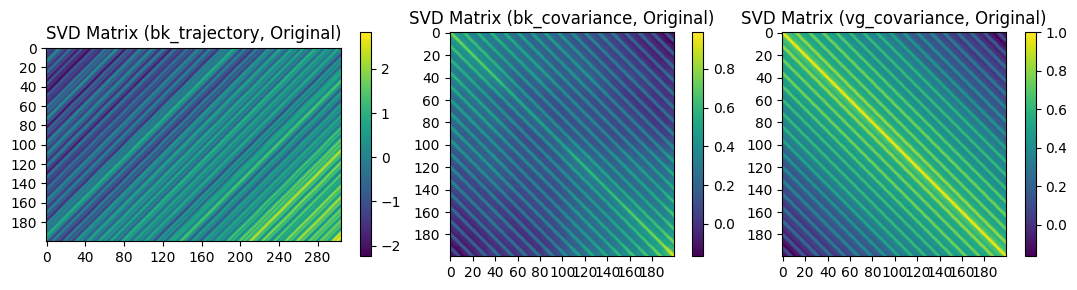

In [3]:
L = 200
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11, 3))
SingularSpectrumAnalysis(sst, window=L, svd_matrix_kind='bk_trajectory').plot(kind='matrix', ax=axes[0])
SingularSpectrumAnalysis(sst, window=L, svd_matrix_kind='bk_covariance').plot(kind='matrix', ax=axes[1])
SingularSpectrumAnalysis(sst, window=L, svd_matrix_kind='vg_covariance').plot(kind='matrix', ax=axes[2])
fig.tight_layout()

## Decomposition Results (Default Window)

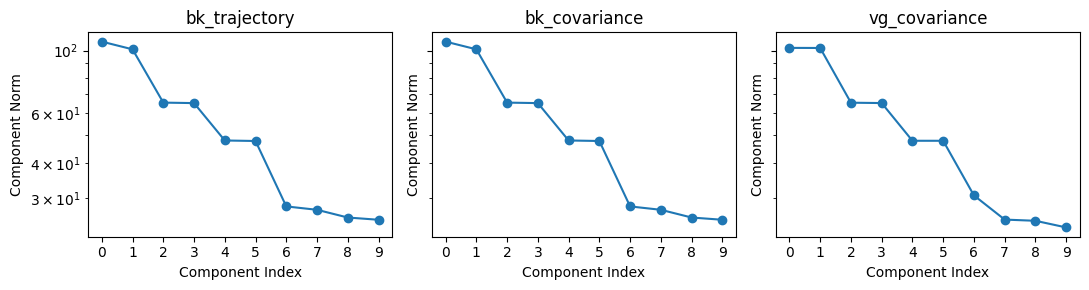

In [4]:
ssa_bk_trajectory.decompose()
ssa_bk_covariance.decompose()
ssa_vg_covariance.decompose()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11, 3), sharey=True)
ssa_bk_trajectory.plot(ax=axes[0], marker='o')
ssa_bk_covariance.plot(ax=axes[1], marker='o')
ssa_vg_covariance.plot(ax=axes[2], marker='o')
titles = ['bk_trajectory', 'bk_covariance', 'vg_covariance']
for i, title in enumerate(titles):
    axes[i].set_title(title, fontsize=12)
fig.tight_layout()

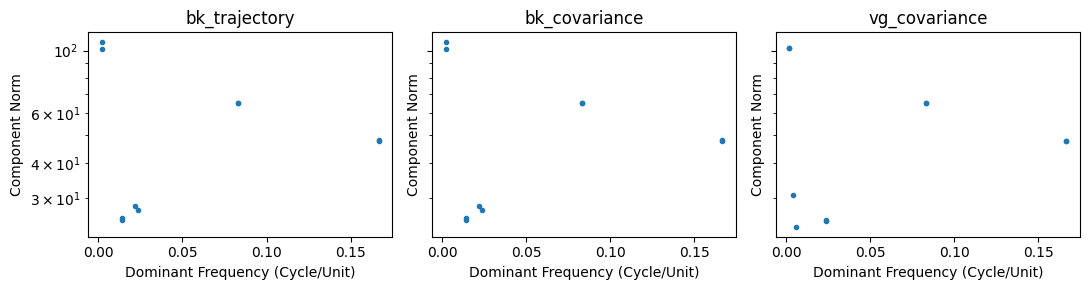

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11, 3), sharey=True)
ssa_bk_trajectory.plot(ax=axes[0], rank_by='freq', ls='none', marker='.')
ssa_bk_covariance.plot(ax=axes[1], rank_by='freq', ls='none', marker='.')
ssa_vg_covariance.plot(ax=axes[2], rank_by='freq', ls='none', marker='.')
titles = ['bk_trajectory', 'bk_covariance', 'vg_covariance']
for i, title in enumerate(titles):
    axes[i].set_title(title, fontsize=12)
fig.tight_layout()

We observe that:
- `bk_trajectory` and `bk_covariance` indeed resulted in the same singular values,
- `vg_covariance` resulted different singular values but the frequencies of the most important components remain similar.

## Reconstruction Results

We compare only `bk_trajectory` and `vg_covariance` since BK approaches are equivalent.

Reconstructed groups contain duplicate indices: [0, 1, 2, 3, 4, 5]
Reconstructed groups contain duplicate indices: [0, 1, 2, 3, 4, 5]


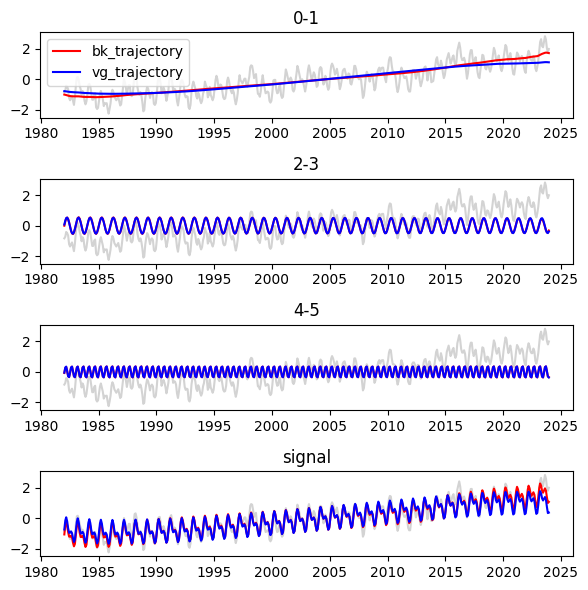

In [6]:
groups = {
    '0-1': [0, 1],
    '2-3': [2, 3],
    '4-5': [4, 5],
    'signal': [0, 1, 2, 3, 4, 5]
}
ssa_bk_trajectory.reconstruct(groups=groups)
ssa_vg_covariance.reconstruct(groups=groups)
fig, axes = plt.subplots(nrows=4, figsize=(6, 6), sharey=True)
for i, group_name in enumerate(groups.keys()):
    axes[i].plot(ssa_bk_trajectory['ssa_preprocessed'], color='lightgrey')
    axes[i].plot(ssa_bk_trajectory[group_name], color='r', label='bk_trajectory')
    axes[i].plot(ssa_vg_covariance[group_name], color='b', label='vg_trajectory')
    axes[i].set_title(group_name, fontsize=12)
    if i == 0:
        axes[i].legend()
fig.tight_layout()


In this case, most differences are related to the trend component reconstructed from the 0 and 1 indices.

## Effect of the Window Size (Default Window)

The `window` size is a crucial parameter in SSA that affects how the time series is decomposed into components. In general,
1. **Range:** \(1 < `window` < N/2\), where \(N\) is the length of the time series.
   - \(`window` = 1\) or \(`window` \geq N/2\) is not valid.
2. **Effect of \(`window`\):**
   - Larger \(`window`\): Finer decomposition with better component separability. Higher computing requirements.
   - Smaller \(`window`\): Most variance of the signal concentrated in the first singular values, capturing a broader frequency range. Lower computing requirements.
  
* For smoothing applications, smaller `window` may be preferred.
* For isolating different components, larger `window` are preferred. For long time series, `window` can be reduced for lowering the computing requirements.
* Using a multiple of a frequency that needs to be captured in another option, e.g., `window=3*12` for a 3-year window.
* Alternatively, the optimal `window` can be evaluated using cross-validation.

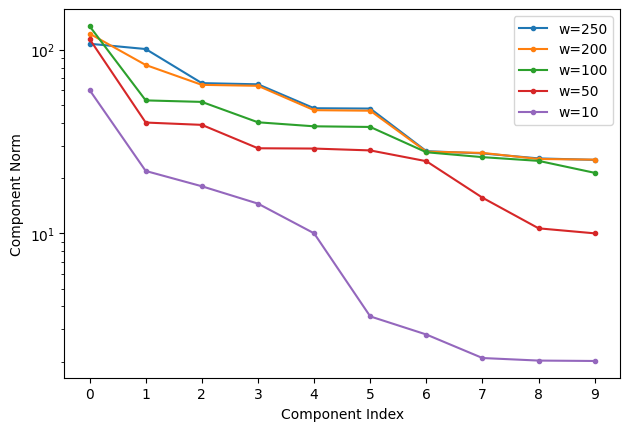

In [7]:
windows = [250, 200, 100, 50, 10]
fig, ax = plt.subplots()
for w in windows:
    ssa = SingularSpectrumAnalysis(sst, window=w).decompose()
    ssa.plot(ax=ax, marker='.', label=f"w={w}")
_ = ax.legend()

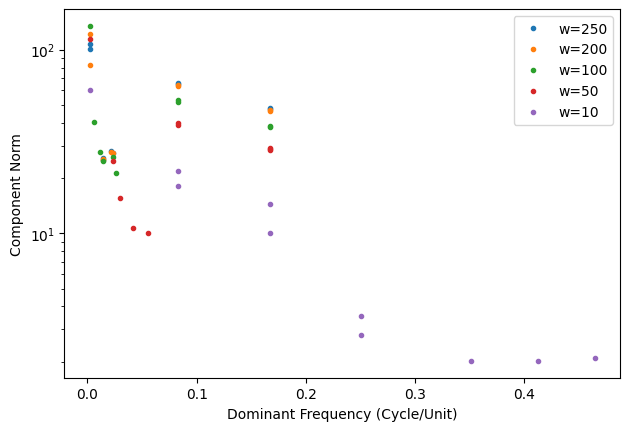

In [8]:
windows = [250, 200, 100, 50, 10]
fig, ax = plt.subplots()
for w in windows:
    ssa = SingularSpectrumAnalysis(sst, window=w).decompose()
    ssa.plot(ax=ax, rank_by='freq', ls='none', marker='.', label=f"w={w}")
_ = ax.legend()

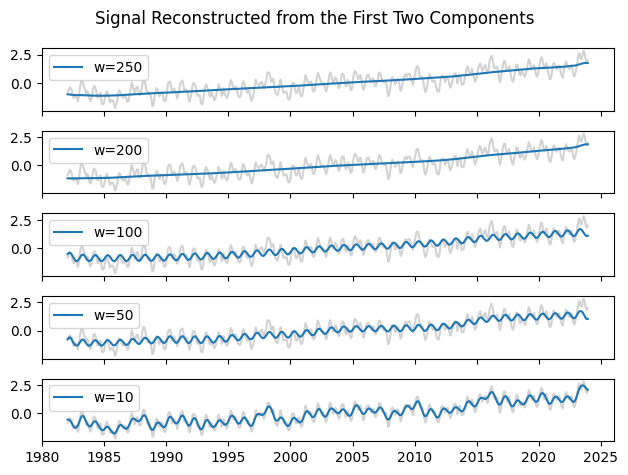

In [9]:
windows = [250, 200, 100, 50, 10]
fig, axes = plt.subplots(5,1, sharex=True, sharey=True)
for i, w in enumerate(windows):
    ssa = SingularSpectrumAnalysis(sst, window=w).decompose()
    axes[i].plot(ssa['ssa_preprocessed'], color='lightgrey')
    axes[i].plot(ssa[:2], label=f"w={w}")
    axes[i].legend()
_ = fig.suptitle('Signal Reconstructed from the First Two Components')
fig.tight_layout()

## Smoothing with SSA

When `window` is significantly smaller than the length of the time series, the principal component acts as an adaptive low-pass frequency filter, similar to a moving average filter with the same `window` or, more precisely, to a [Bartlett window filter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.bartlett.html#scipy.signal.windows.bartlett) of size 2*`window`.

This SSA feature is particularly useful for filtering out specific frequencies, with the added advantage of not truncating the signal on the edges.

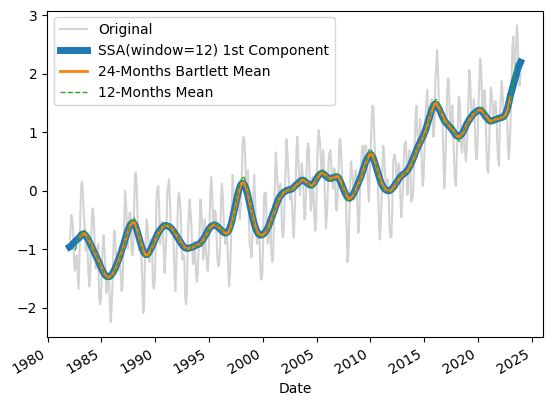

In [10]:
ssa_12 = SingularSpectrumAnalysis(sst, window=12).decompose()
fig, ax = plt.subplots()
ssa_12['ssa_preprocessed'].plot(ax=ax, label='Original', color='lightgrey')
ssa_12[0].plot(ax=ax, lw=5., label='SSA(window=12) 1st Component')
ssa_12['ssa_preprocessed'].rolling(
    window=24, win_type='bartlett', center=True
).mean().plot(ax=ax, lw=2., label='24-Months Bartlett Mean')
ssa_12['ssa_preprocessed'].rolling(
    window=12, win_type='boxcar', center=True # boxcar is a rectangular window
).mean().plot(ax=ax, lw=1., ls='--', label='12-Months Mean')
_ = ax.legend()

## References

1. Broomhead, D. S., & King, G. P. (1986). Extracting qualitative dynamics from experimental data. Physica D: Nonlinear Phenomena, 20(2), 217–236. https://doi.org/10.1016/0167-2789(86)90031-X
2. Vautard, R., & Ghil, M. (1989). Singular spectrum analysis in nonlinear dynamics, with applications to paleoclimatic time series. Physica D: Nonlinear Phenomena, 35(3). https://doi.org/10.1016/0167-2789(89)90077-8
3. Golyandina, N., & Zhigljavsky, A. (2020). Singular Spectrum Analysis for Time Series. Berlin, Heidelberg: Springer. https://doi.org/10.1007/978-3-662-62436-4